# Creating Labeled Data from a Planet Mosaic with Label Maker

In this notebook, we create labeled data for training a machine learning algorithm. As inputs, we use [OpenStreetMap](https://www.openstreetmap.org/#map=4/38.01/-95.84) as the ground truth source and a Planet mosaic as the image source. Development Seed's [Label Maker](https://developmentseed.org/blog/2018/01/11/label-maker/) tool is used to download and prepare the ground truth data, chip the Planet imagery, and package the two to feed into the training process.

The primary interface for Label Maker is through the command-line interface (cli). It is configured through the creation of a configuration file. More information about that configuration file and command line usage can be found in the Label Maker repo [README](https://github.com/developmentseed/label-maker/blob/master/README.md).

**RUNNING NOTE**

This notebook is meant to be run in a docker image specific to this folder. The docker image must be built from the custom [Dockerfile](Dockerfile) according to the directions below.

In label-data directory:
```
docker build -t planet-notebooks:label .
```

Then start up the docker container as you usually would, specifying `planet-notebooks:label` as the image.

## Install Dependencies

In addition to the python packages imported below, the label-maker python package is also a dependency. However, it's primary usage is through the command-line interface (cli), so we use juypter notebook bash magic to run label-maker via the cli instead of importing the python package.

In [1]:
import json
import os

import ipyleaflet as ipyl
import ipywidgets as ipyw
from IPython.display import Image
import numpy as np

## Define Mosaic Parameters

In this tutorial, we use the Planet mosaic [tile service](https://developers.planet.com/docs/api/tile-services/). There are many mosaics to choose from. For a list of mosaics available, visit https://api.planet.com/basemaps/v1/mosaics.

We first build the url for the xyz basemap tile service, then we add authorization in the form of the Planet API key.

In [2]:
# Planet tile server base URL (Planet Explorer Mosaics Tiles)
mosaic = 'global_monthly_2018_02_mosaic'
mosaicsTilesURL_base = 'https://tiles.planet.com/basemaps/v1/planet-tiles/{}/gmap/{{z}}/{{x}}/{{y}}.png'.format(mosaic)
mosaicsTilesURL_base

'https://tiles.planet.com/basemaps/v1/planet-tiles/global_monthly_2018_02_mosaic/gmap/{z}/{x}/{y}.png'

In [3]:
# Planet tile server url with auth
planet_api_key = os.environ['PL_API_KEY']
planet_mosaic = mosaicsTilesURL_base + '?api_key=' + planet_api_key
# url is not printed because it will show private api key

## Prepare label maker config file

This config file is pulled from the label-maker repo [README.md](https://github.com/developmentseed/label-maker/blob/master/README.md) example and then customized to utilize the Planet mosaic. The imagery url is set to the Planet mosaic url and the zoom is changed to 15, the maximum zoom supported by the [Planet tile services](https://developers.planet.com/docs/api/tile-services/).

See the label-maker README.md file for a description of the config entries.

In [4]:
# create data directory
data_dir = os.path.join('data', 'label-maker-mosaic')
if not os.path.isdir(data_dir):
    os.makedirs(data_dir)

In [5]:
# label-maker doesn't clean up, so start with a clean slate
!cd $data_dir && rm -R *

rm: cannot remove '*': No such file or directory


In [6]:
# create config file
bounding_box = [1.09725, 6.05520, 1.34582, 6.30915]

config = {
  "country": "togo",
  "bounding_box": bounding_box,
  "zoom": 15,
  "classes": [
    { "name": "Roads", "filter": ["has", "highway"] },
    { "name": "Buildings", "filter": ["has", "building"] }
  ],
  "imagery": planet_mosaic,
  "background_ratio": 1,
  "ml_type": "classification"
}

# define project files and folders
config_filename = os.path.join(data_dir, 'config.json')

# write config file
with open(config_filename, 'w') as cfile:
    cfile.write(json.dumps(config))

print('wrote config to {}'.format(config_filename))

wrote config to data/label-maker-mosaic/config.json


### Visualize Mosaic at config area of interest

In [7]:
# calculate center of map
bounds_lat = [bounding_box[1], bounding_box[3]]
bounds_lon = [bounding_box[0], bounding_box[2]]
def calc_center(bounds):
    return bounds[0] + (bounds[1] - bounds[0])/2

map_center = [calc_center(bounds_lat), calc_center(bounds_lon)] # lat/lon
print(bounding_box)
print(map_center)

[1.09725, 6.0552, 1.34582, 6.30915]
[6.182175, 1.221535]


In [8]:
# create and visualize mosaic at approximately the same bounds as defined in the config file
map_zoom = 12
layout=ipyw.Layout(width='800px', height='800px') # set map layout
mosaic_map = ipyl.Map(center=map_center, zoom=map_zoom, layout=layout)

mosaic_map.add_layer(ipyl.TileLayer(url=planet_mosaic))
mosaic_map

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [9]:
mosaic_map.bounds

((6.045650255394285, 1.0842132568359377),
 (6.3187109204912915, 1.3588714599609375))

## Download OSM tiles

In this step, label-maker downloads the OSM vector tiles for the country specified in the config file.

According to Label Maker documentation, these can be visualized with [mbview](https://github.com/mapbox/mbview). So far I have not been successful getting mbview to work. I will keep on trying and would love to hear how you got this to work!

In [10]:
!cd $data_dir && label-maker download

Saving QA tiles to data/togo.mbtiles
   100%     27.4 MiB       1.5 MiB/s            0:00:00 ETA    


## Create ground-truth labels from OSM tiles

In this step, the OSM tiles are chipped into label tiles at the zoom level specified in the config file. Also, a geojson file is created for visual inspection.

In [11]:
!cd $data_dir && label-maker labels

Retiling QA Tiles to zoom level 15 (takes a bit)
175567 features, 11104945 bytes of geometry, 5238 bytes of separate metadata, 2562819 bytes of string pool
  99.9%  15/16488/15816  
Determining labels for each tile
---
Roads: 371 tiles
Buildings: 273 tiles
Total tiles: 576
Writing out labels to data/labels.npz


Visualizing `classification.geojson` in QGIS gives:

![classification.geojson visualization](images/vis-classification.png)

Although Label Maker doesn't tell us which classes line up with the labels (see the legend in the visualization for labels), it looks like the following relationships hold:
- (1,0,0) - no roads or buildings
- (0,1,1) - both roads and buildings
- (0,0,1) - only buildings
- (0,1,0) - only roads

Most of the large region with no roads or buildings at the bottom portion of the image is the water off the coast.

## Preview image chips

Create a subset of the image chips for preview before creating them all. Preview chips are placed in subdirectories named after each class specified in the config file.

**NOTE** This section is commented out because preview fails due to imagery-offset arg. See more:
https://github.com/developmentseed/label-maker/issues/79

In [23]:
# !cd $data_dir && label-maker preview -n 3

In [24]:
# !ls $data_dir/data/examples

In [25]:
# for fclass in ('Roads', 'Buildings'):
#     example_dir = os.path.join(data_dir, 'data', 'examples', fclass)
#     print(example_dir)
#     for img in os.listdir(example_dir):
#         print(img)
#         display(Image(os.path.join(example_dir, img)))

Other than the fact that 4 tiles were created instead of the specified 3, the results look pretty good! All Road examples have roads, and all Building examples have buildings.

## Create image tiles

In this step, we invoke `label-maker images`, which downloads and chips the mosaic into tiles that match the label tiles.

Interestingly, only 372 image tiles are downloaded, while 576 label tiles were generated. Looking at the label tile generation output (370 Road tiles, 270 Building tiles) along with the `classification.geojson` visualization (only two tiles that are Building and not Road), we find that there are only 372 label tiles that represent at least one of the Road/Building classes. This is why only 372 image tiles were generated.

In [26]:
!cd $data_dir && label-maker images

data/label-maker-mosaic/data/tiles
16490-15812-15.png


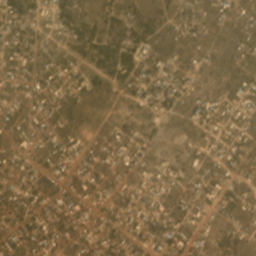

16498-15813-15.png


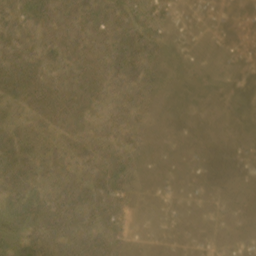

16506-15818-15.png


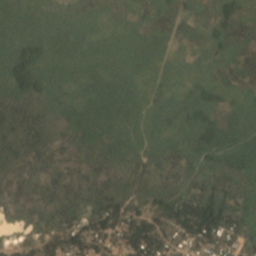

In [27]:
# look at three tiles that were generated
tiles_dir = os.path.join(data_dir, 'data', 'tiles')
print(tiles_dir)
for img in os.listdir(tiles_dir)[:3]:
    print(img)
    display(Image(os.path.join(tiles_dir, img)))

## Package tiles and labels

Convert the image and label tiles into train and test datasets.

In [28]:
# will not be able to open image tiles that weren't generated because the label tiles contained no classes
!cd $data_dir && label-maker package

Saving packaged file to data/data.npz


## Check Package

Let's load the packaged data and look at the train and test datasets.

In [29]:
data_file = os.path.join(data_dir, 'data', 'data.npz')
data = np.load(data_file)

In [30]:
for k in data.keys():
    print('data[\'{}\'] shape: {}'.format(k, data[k].shape))

data['x_train'] shape: (297, 256, 256, 4)
data['y_train'] shape: (297, 3)
data['x_test'] shape: (75, 256, 256, 4)
data['y_test'] shape: (75, 3)


297 x (image) and y (label) datasets were created in the train set, and 75 x and y datasets were created in the test set, adding up to 372 sets total, equal to the number of image tiles downloaded.

## Next Steps

The next step after creating labeled data is to train the machine learning algorithm.

This Development Seed [walkthrough](https://github.com/developmentseed/label-maker/blob/master/examples/walkthrough-classification-aws.md) demonstrates how to train a neural network classifier.